In [ ]:
!pip install -U classiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing insta

In [ ]:
import classiq
classiq.authenticate()

/usr/local/lib/python3.10/dist-packages/classiq/_internals/authentication/token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


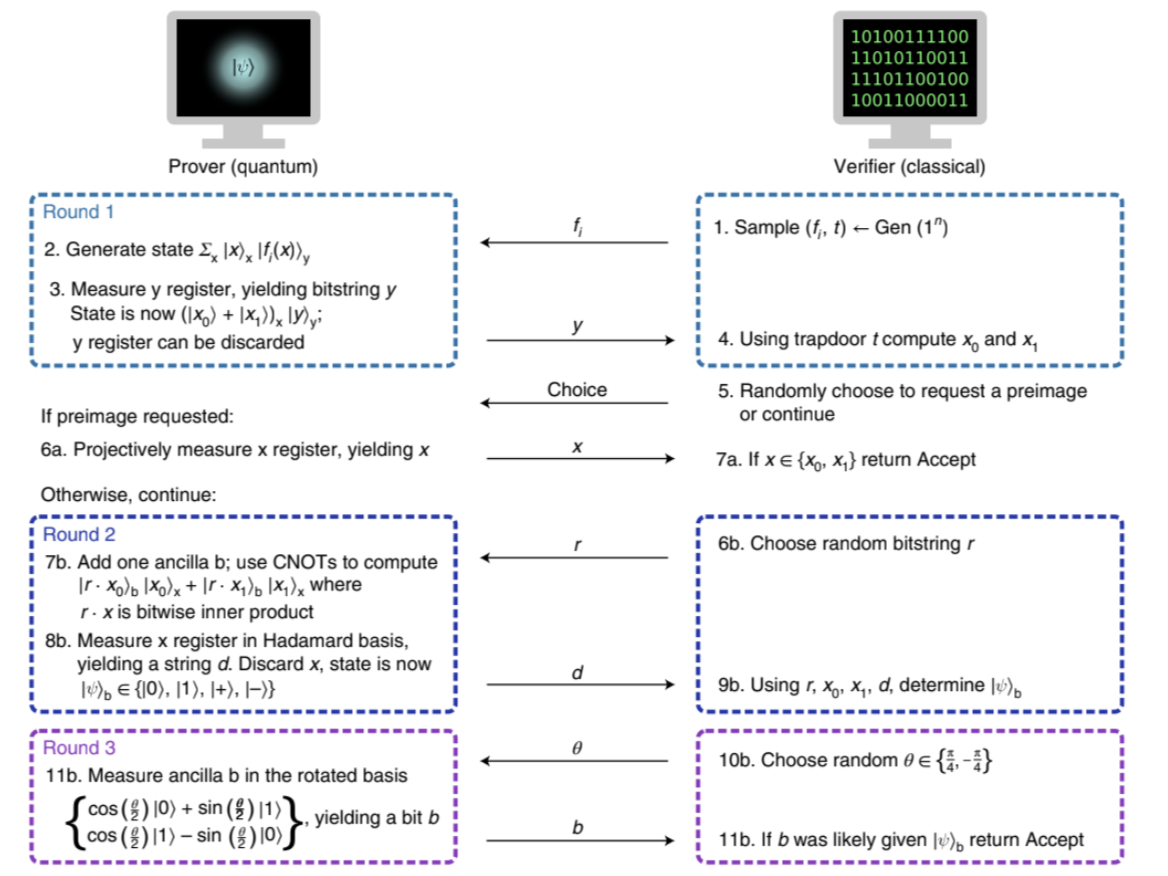

In [1]:
from classiq import *

# Round 1

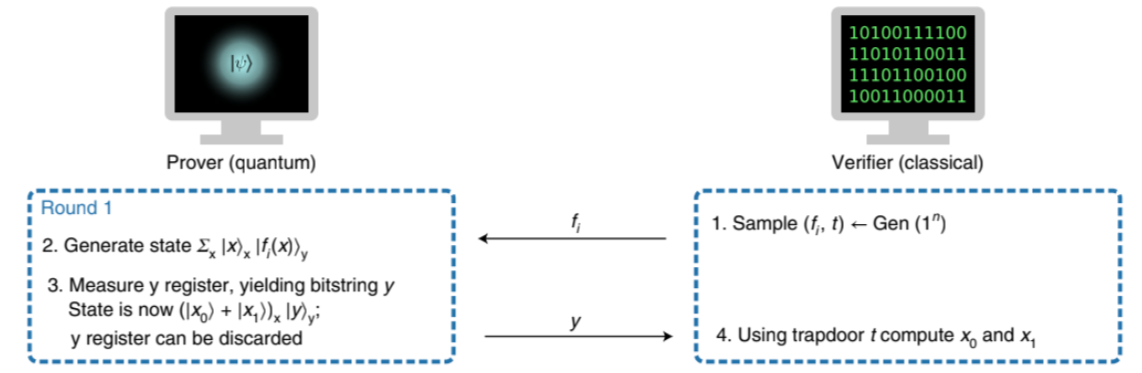

In [3]:
from classiq.qmod.symbolic import pi
import numpy as np
N = 15 # N = 2*3 prime factorization

Y_SIZE = int(np.ceil(np.log2(N))) ## y_size = ceil(log_2(N))
X_SIZE = Y_SIZE # X_size is the domain of N
print(N, X_SIZE,Y_SIZE)

15 4 4


In [5]:
@qfunc
def apply_rotations_diff_ij(N: CInt, i: CInt, j: CInt , ctrl1: QBit,
                    ctrl2: QBit,y: QArray):
    ctrl = QArray('ctrl')
    bind([ctrl1, ctrl2], ctrl)
    control(ctrl,
      lambda: repeat(Y_SIZE, lambda k: PHASE(2 * pi*(2**(i+j+k))/N,y[k]))) ## not kept - Extra factor of 2 in the phase as i!=j are twice in the ij matrix.
    bind(ctrl, [ctrl1, ctrl2])
@qfunc
def apply_rotations(N: CInt, i: CInt, ctrl1: QBit,
                    y: QArray):
    control(ctrl1,
      lambda: repeat(Y_SIZE, lambda k: PHASE(2 * pi*(2**(2*i+k))/N,y[k])))

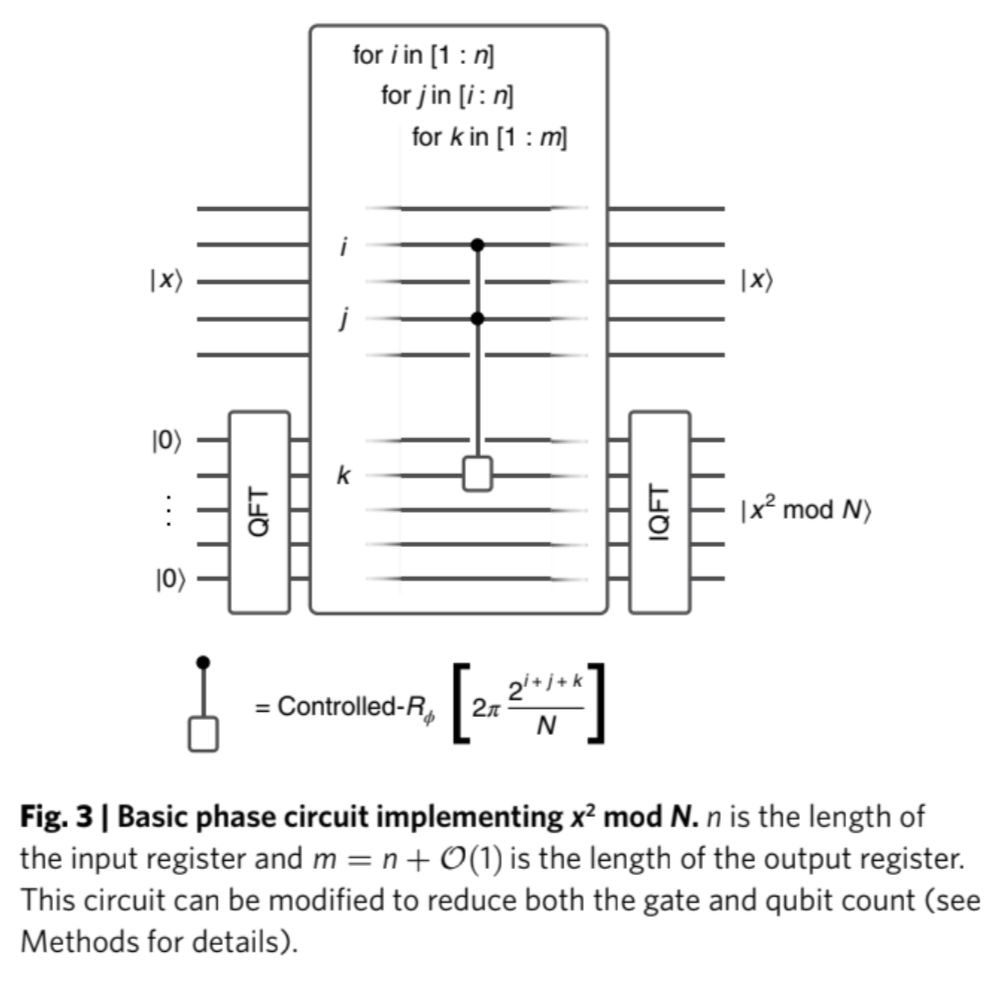

In [8]:
@qfunc
def apply_rotations_diff_ij1(N: CInt, i: CInt, j: CInt , ctrl1: QBit,
                            ctrl2: QBit, y: QArray):
    ctrl = QArray('ctrl')
    bind([ctrl1, ctrl2], ctrl)
    control(ctrl,
            lambda: repeat(Y_SIZE, lambda k: PHASE(2 * pi * ((2 ** (i + j + k)) % N) / N, y[k])))
    bind(ctrl, [ctrl1, ctrl2])

@qfunc
def apply_rotations1(N: CInt, i: CInt, ctrl1: QBit, y: QArray):
    control(ctrl1,
            lambda: repeat(Y_SIZE, lambda k: PHASE(2 * pi * ((2 ** (2 * i + k)) % N) / N, y[k])))

In [10]:
#qfunc
def modular_square(N: CInt, x: QArray[QNum], y: QArray[QNum]):
    hadamard_transform(y)
    for i in range(X_SIZE):
        apply_rotations1(N, i, x[i], y)
        for j in range(i+1, X_SIZE):
            apply_rotations_diff_ij1(N, i, i + j + 1, x[i], x[j], y)
    invert(lambda : qft(y))

In [12]:
N = 8                                # N = 2*3 prime factorization
Y_SIZE = int(np.ceil(np.log2(N)))     # y_size = ceil(log_2(N))
X_SIZE = int(np.ceil(np.log2(N)))      # X_size is the domain of N
print(Y_SIZE, X_SIZE)

@qfunc
def main(x: Output[QArray],y: Output[QArray]):
#def main(y: Output[QArray]):
    #N = 8
    #x = QArray("x")
    allocate(X_SIZE, x)
    allocate(Y_SIZE, y)
    #inplace_prepare_int(3, x)
    hadamard_transform(x)
    modular_square(N, x, y)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
res = execute(qprog).result()
res[0].value.parsed_counts

3 3
Opening: https://platform.classiq.io/circuit/09e3aa09-f652-45d1-a34c-9cf5e9d1b412?version=0.44.0


[{'x': [0, 1, 0], 'y': [0, 0, 1]}: 270,
 {'x': [1, 1, 1], 'y': [1, 0, 0]}: 267,
 {'x': [0, 1, 1], 'y': [0, 0, 1]}: 261,
 {'x': [1, 0, 0], 'y': [1, 0, 0]}: 261,
 {'x': [1, 0, 1], 'y': [1, 0, 0]}: 255,
 {'x': [1, 1, 0], 'y': [1, 0, 0]}: 249,
 {'x': [0, 0, 1], 'y': [0, 0, 0]}: 243,
 {'x': [0, 0, 0], 'y': [0, 0, 0]}: 242]

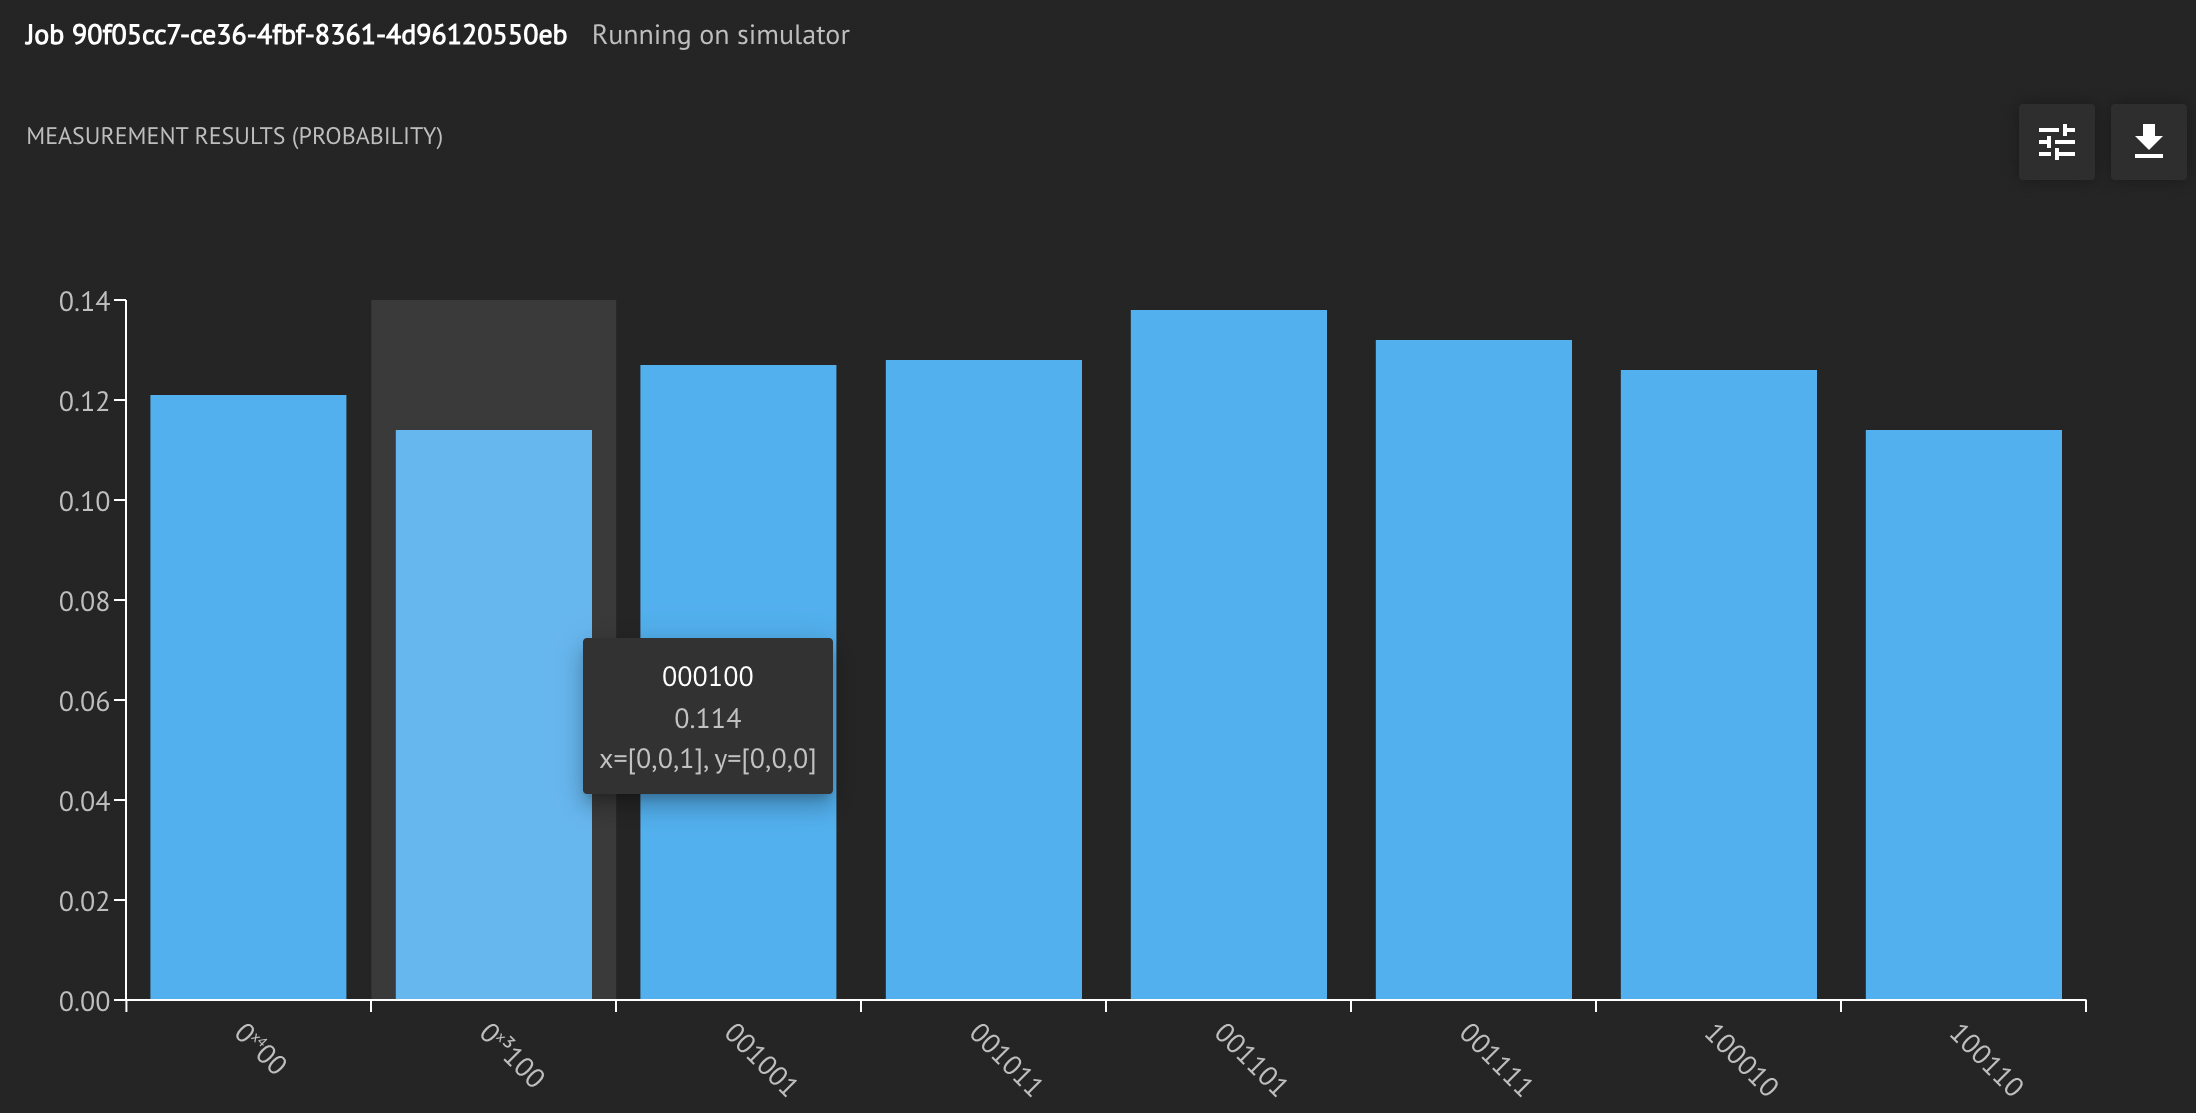

Details of above plot :
* Y-axis : Probability
* X-axis : [y-bit,x-bit] written as [y[2],y[1],y[0] ,x[2],x[1],x[0]] (for example highlighted histogram : x-qbit = 4, y-qbit=0).

According to this execution, roughly every x-qubit has the same probability of occurence (~0.125 = 1/8)
Quantum circuit : Opening: https://platform.classiq.io/circuit/ea0b6cc8-cc1a-4c1e-b4d1-3fc85aaa4dcd?version=0.44.0


RESOURCE ESTIMATION FOR ROUND 1

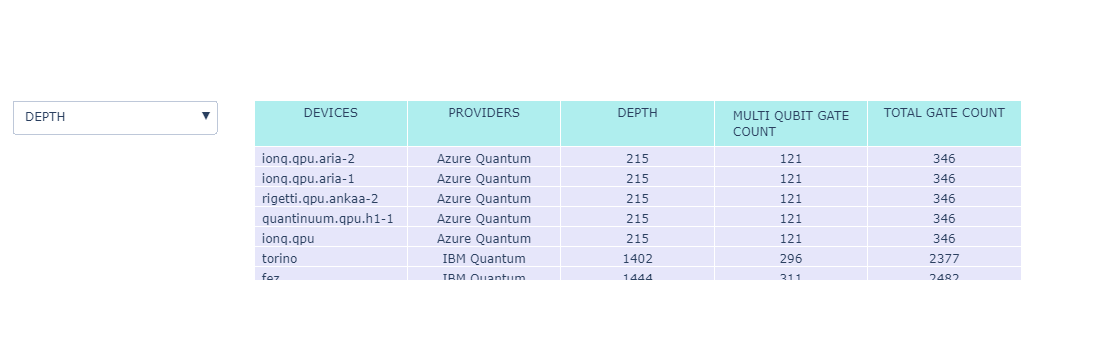

In [16]:
providers = ["Classiq", "Azure Quantum" , "IBM Quantum", ]
analyzer = Analyzer(circuit = QuantumProgram.from_qprog(qprog))
analyzer.get_hardware_comparison_table(providers = providers)
analyzer.plot_hardware_comparison_table()


The results of optimizing the circuit for depth on a specific hardware simulator

In [19]:
from classiq.execution import AzureBackendPreferences, ExecutionPreferences
from classiq.synthesis import set_execution_preferences
preferences = Preferences(backend_service_provider = "Azure Quantum", backend_name = "ionq")
contraints = Constraints(optimization_parameter="depth", max_width = 100)
model = create_model(main, contraints, preferences)
q = synthesize(model)
circuit = QuantumProgram.from_qprog(q)
print("Width = ", circuit.data.width)
print("Depth = ", circuit.transpiled_circuit.depth)
print(circuit.transpiled_circuit.get_circuit_metrics())

Width =  6
Depth =  202
depth=202 count_ops={'u': 121, 'cx': 121}


# Round 2 and 3

In [33]:
import random

def set_k_based_on_i():
    # Randomly select i as 0 or 1
    i = random.choice([0, 1])

    # Set the value of k based on the value of i
    if i == 0:
        k = 7
    else:
        k = 8

    return i, k

# Call the function and print the result
i, k = set_k_based_on_i()
print(f"i: {i}, k: {k}")


i: 1, k: 8


In [40]:
import random
from classiq.qmod import (
    CInt,
    Output,
    QArray,
    QBit,
    QNum,
    allocate,
    inplace_prepare_int,
    modular_exp,
    qfunc,
    hadamard_transform,
    qft,
    PHASE,
    control,
    X,
    create_model,
    RY
)
import math
theta=math.pi/4
from classiq import Preferences, show, synthesize, write_qmod

# Function to generate a random bitstring of given length
def generate_random_bitstring(length):
    return [random.randint(0, 1) for _ in range(length)]

# Length of the bitstring
bitstring_length = 4

# Generate random bitstring
random_bitstring = generate_random_bitstring(bitstring_length)
print("Random Bitstring:", random_bitstring)

@qfunc
def main(
    x: Output[QArray[QBit]],
    auxiliary: Output[QNum],
) -> None:
    # Allocate 2 qubits for x and 1 qubit for the auxiliary
    allocate(4, x)
    allocate(1, auxiliary)
   # hadamard_transform(x)

    # Apply Hadamard gates to the x register to create superposition
    inplace_prepare_int(k,x)

    # Apply CNOT gates conditionally based on the random bitstring
    # This calculates the inner product and stores it in the auxiliary qubit
    for i, bit in enumerate(random_bitstring):
        if bit == 1:
            control(ctrl=x[i], operand=lambda: X(auxiliary))
    hadamard_transform(x)
    #theta=math.pi/4
    RY(theta,auxiliary)
# Create the quantum model
qmod = create_model(main)

# Write the model to a file
write_qmod(qmod, "CX")

# Synthesize the quantum program
qprog = synthesize(qmod)

# Show the quantum program
show(qprog)


Random Bitstring: [0, 1, 1, 1]


C:\Users\barno\AppData\Local\Temp\ipykernel_16728\3217135986.py:52: DeprecationWarning:

Parameter 'operand' of function 'control' has been renamed to 'stmt_block'. Parameter 'operand' will be deprecated in a future release.
Hint: Change `control(ctrl=..., operand=...)` to `control(ctrl=..., stmt_block=...)` or `control(..., ...)`.



Opening: https://platform.classiq.io/circuit/829af10d-a6ff-474f-a43b-a27564c4bee4?version=0.44.0


RESOURCE ESTIMATION FOR ROUND 2

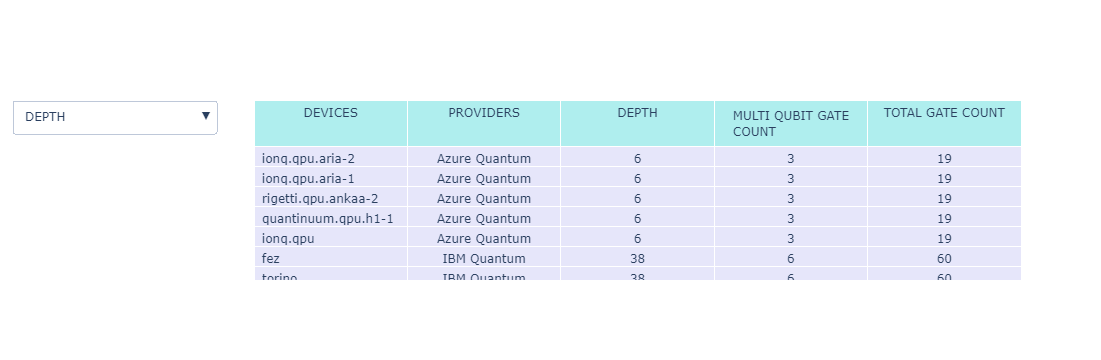

In [42]:
providers = ["Classiq", "Azure Quantum" , "IBM Quantum", ]
analyzer = Analyzer(circuit = QuantumProgram.from_qprog(qprog))
analyzer.get_hardware_comparison_table(providers = providers)
analyzer.plot_hardware_comparison_table()

The results of optimizing the circuit for depth on a specific hardware simulator

In [44]:
from classiq.execution import AzureBackendPreferences, ExecutionPreferences
from classiq.synthesis import set_execution_preferences
preferences = Preferences(backend_service_provider = "Azure Quantum", backend_name = "ionq")
contraints = Constraints(optimization_parameter="width", max_depth = 6 )
model = create_model(main, contraints, preferences)
q = synthesize(model)
circuit = QuantumProgram.from_qprog(q)
print("Width = ", circuit.data.width)
print("Depth = ", circuit.transpiled_circuit.depth)
print(circuit.transpiled_circuit.get_circuit_metrics())

C:\Users\barno\AppData\Local\Temp\ipykernel_16728\3217135986.py:52: DeprecationWarning:

Parameter 'operand' of function 'control' has been renamed to 'stmt_block'. Parameter 'operand' will be deprecated in a future release.
Hint: Change `control(ctrl=..., operand=...)` to `control(ctrl=..., stmt_block=...)` or `control(..., ...)`.



Width =  5
Depth =  4
depth=4 count_ops={'u': 6, 'cx': 3}
